In [1]:
import re
import os
from os import listdir
from os.path import isfile, join
from pathlib import Path
import pandas as pd
import json
import pickle
from typing import Dict, List, get_type_hints
from styleframe import StyleFrame, Styler
from IPython.display import display

''' 自己寫的模組 '''
from cc_regex_script import RegexMatchResult, RegexMaster 
from cc_nlp_script import find_verb_of_vocab, OperationMode, OperationEvaluator
from ASG import AttackGraph, Node, Edge, FileTable #, build
import Utility

c:\Users\luweb\AppData\Local\Programs\Python\Python310\lib\site-packages\tqdm\auto.py:22: TqdmWarning:IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html


### Load 所有 ASG 的 trace logs

In [2]:
family = 'Xorddos' # Dofloo Xorddos Darlloz

if family == 'Dofloo':
    samplename_lst = ['0046a78514a658b9b7a4e29e8581f85b'] # 只先使用這個 dof sample
if family == 'Xorddos':
    samplename_lst = ['0aefb67c01a24d05351b093455203fa2'] # 只先使用這個 xor sample
if family == 'Darlloz':
    samplename_lst = ['dfeb77cb0ba28ac3ba4be55d7bc91fad'] # 只先使用這個 dar sample
if family == 'Gafgyt':
    samplename_lst = ['933e9eff97f50b196b2bb0fef499640e'] # 只先使用這個 gaf sample
if family == 'Luabot':
    samplename_lst = ['a220940db4be6878e47b74403a8079a1'] # 只先使用這個 lua sample
if family == 'Lupper':
    samplename_lst = ['b4ba07c4d9b781635b33d485b73a614f'] # 只先使用這個 lup sample
if family == 'Turla':
    samplename_lst = ['19fbd8cbfb12482e8020a887d6427315'] # 只先使用這個 tur sample

print('samplename:', samplename_lst)

samplename: ['0aefb67c01a24d05351b093455203fa2']


In [3]:
def prettifyName(item:str) -> str:
    pretty_name = {
        r"\d{1,3}\.\d{1,3}\.\d{1,3}\.\d{1,3}": "ip_addr/ip_addr:port/port",
        r"\d{1,3}\.\d{1,3}\.\d{1,3}\.\d{1,3}:\d+": "ip_addr/ip_addr:port/port", 
        r"\d{1,3}\.\d{1,3}\.\d{1,3}\.\d{1,3}:d+":  "ip_addr/ip_addr:port/port",
        r"0x[0-9a-zA-Z]{8}": "0x[0-9a-zA-Z]{8} (mem)",       # old
        r"0x[0-9a-zA-Z]{1,16}": "0x[0-9a-zA-Z]{1,16} (mem)", # new
        r"Permission":                 'Permission/Permission:[0-9]{3}',
        r"Permission:[0-9]{3}":        'Permission/Permission:[0-9]{3}',
        # r"permission:{0,1}[0-9]{0,4}": 'Permission/Permission:[0-9]{3}'
    }
    changed = pretty_name.get(item, None)
    if changed:
        return changed
    return item

class PrettyJson(dict):
	def __str__(self):
		return json.dumps(self, indent=4, sort_keys=True)
# myJSON = PrettyJson(student) # usage

class OperationPair:
    SYSCALL = 0
    VERB = 1    # not use now (may cause confused)

    def __init__(self, action:str, object:str, isSyscall:bool=False, subject:str=None, \
                 step_number:int=None , original_object=None, \
                 original_sentence=None, object_type=None):
        self.object:str = object # regex
        self.action:str = action # verb or syscall
        self.isSyscall:bool = isSyscall # action type (syscall or verb)
        self.object_type:str = object_type # FILE, NET, PROC, MEM, INFO
        self.subject:str = subject
        self.step_number:int = step_number
        self.original_object:str = original_object # can store original matched word (object) from CTD
        self.original_sentence:str = original_sentence # can store the mathced sentence
        self.altVerb:str = None # can store the alternative verb if the origin verb is not in the rule
        pass

    def __eq__(self, other): 
        if not isinstance(other, OperationPair):
            # don't attempt to compare against unrelated types
            return NotImplemented
        # Same if <action, object> pair is same (type is not consider yet)
        return self.action == other.action and self.object == other.object

    def __hash__(self) -> int:
        # necessary for instances to behave sanely in dicts and sets.
        return hash((self.action, self.object))

    def _getActionStr(self) -> str:
        if self.isSyscall:
            return f"{self.action}()"
        return self.action
    def __str__(self) -> str:
        if self.step_number:
            return f"<OP{self.step_number:>2} act={self._getActionStr()}, obj={prettifyName(self.object)}>"
        return f"<OP act={self._getActionStr()}, obj={prettifyName(self.object)}>"
    def __repr__(self) -> str:
        return str(self)
    def getSentStr(self) -> str:
        '''return string contains original_object & flat_sentence'''
        flat_sentence = " ".join(self.original_sentence.splitlines())
        return f"<OP{self.step_number:>2} act={self._getActionStr()}, obj={prettifyName(self.original_object)}, sent={flat_sentence}>"
        
# test case
p_aa = OperationPair('a','a')
p_aaz = OperationPair('a','a')
p_ab = OperationPair('a','b')

print(p_aa == p_aaz) # True
print(set([p_aa, p_aaz])) # one element

def construct_sample_OPset(step_list: list, regexMaster:RegexMaster, keep_src_node=False, debug=False, 
                           rt_order=True, draw_memory_etc=False) -> set | tuple[set, list]:
    '''return a list of OPset. RegexMaster and family are gobal variable.
     If draw_memory_etc = True, 則會特別處理記憶體, 網路, 權限等節點的 dst_node.'''
    if debug:
        print('step_list len:', len(set(step_list)))
    OPlst_raw = list((src_node.name, dst_node.name, syscall) for (src_node, dst_node, syscall) in step_list) # object is raw
    OPset_raw = list(dict.fromkeys(OPlst_raw))
    if debug:
        print('OPlst_raw len:', len(OPlst_raw)) # why len is 123100? (while step_list len is 7775) (must be equal)
        print(f"OPlst_raw: {OPlst_raw[:10]}")
        print('OPset_raw len:', len(OPset_raw)) # len is 5925 for xor
        print(f"OPset_raw: {OPset_raw[:10]}")
    # regexMaster = RegexMaster()
    # regex_pool = regexMaster.get_all_regex()
    OPset = set()
    OPset_ordered = list()
    for (src_node, dst_node, syscall) in OPset_raw:
        # regex_dst_node_list = RegexMaster.find_spacial_token_with_regex(regex_pool, dst_node)
        regex_dst_node_list:list[RegexMatchResult] = regexMaster.find_spacial_token(dst_node)

        # 0509 加的，為了畫圖
        if draw_memory_etc and dst_node in ['Memory Address', 'NIC', ]:
            if dst_node == 'Memory Address':
                txt = 'Memory Address'
                regex_dst_node_list = [RegexMatchResult(txt, match_regex='0x[0-9a-zA-Z]{1,16}', type='MEM')]
            else:
                txt = 'NIC'
                regex_dst_node_list = [RegexMatchResult(txt, match_regex='^eth.*', type='NET')]
        if draw_memory_etc and dst_node in ['\\d{1,3}\\.\\d{1,3}\\.\\d{1,3}\\.\\d{1,3}', 'port \\d+', 
                                            '\\d{1,3}\\.\\d{1,3}\\.\\d{1,3}\\.\\d{1,3}:\\d+']:
            txt = 'ip_addr/ip_addr:port/port'
            regex_dst_node_list = [RegexMatchResult(txt, match_regex=txt, type='NET')]
        if draw_memory_etc and dst_node in ['Permission', 'Permission:[0-9]{3}']:
            txt = 'Permission/Permission:[0-9]{3}'
            regex_dst_node_list = [RegexMatchResult(txt, match_regex=txt, type='FILE')]

        if regex_dst_node_list is None or len(regex_dst_node_list) == 0:
            continue
        for regex_result in regex_dst_node_list:
            dst_node = regex_result.match_regex
            step_number = len(OPset) + 1
            if keep_src_node:
                op = OperationPair(syscall, dst_node, subject=src_node, isSyscall=True,\
                                   step_number=step_number, object_type=regex_result.type)
                OPset.add(op) # keep src_node in OP
                if op not in OPset_ordered:
                    OPset_ordered.append(op)
            else:
                op = OperationPair(syscall, dst_node, isSyscall=True,\
                                   step_number=step_number, object_type=regex_result.type)
                OPset.add(op) # only dst_node, syscall in OP
                if op not in OPset_ordered:
                    OPset_ordered.append(op)
    if debug:
        print('OPset len:', len(OPset), 'OPset_ordered len:', len(OPset_ordered))
    if rt_order:
        return OPset, OPset_ordered
    return OPset

# test
# sample_OPset = construct_sample_OPset(asg.step_list, debug=True)

True
{<OP act=a, obj=a>}


### Create ASG object and Sample object，計算並儲存其 regex

In [4]:
class Sample:
    def __init__(self, samplename:str, regex_set:set=None, special_token_dict=None, \
                 step_list=None, regexMaster=None) -> None:
        self.samplename: str = samplename
        self.regexMaster = None
        if regexMaster:
            self.regexMaster = regexMaster
        self.regex_set: set = set()
        if regex_set:
            self.regex_set = regex_set
        self.special_token_dict = {}
        if special_token_dict:
            self.special_token_dict: dict = special_token_dict # list of dict
        if step_list:
            self.step_list = step_list
            OPset, OPset_ordered = construct_sample_OPset(step_list, self.regexMaster, draw_memory_etc=True)
            self.OPset: set[OperationPair] = OPset
            self.OPset_ordered: list[OperationPair] = OPset_ordered # 依照出現順序排序的 OPset (元素相同順序不同)
            self.OPset_sysOnly_ordered = [] # 尚未初始化 只儲存改變系統狀態的 OP 的物件
            self.OPset_sysOnly_ordered_index = [] # 尚未初始化 只儲存改變系統狀態的 OP 的 index
            self.ASGstep_sysOnly_ordered_index = [] # 尚未初始化 只儲存改變系統狀態的 ASG 的 index
            del OPset, OPset_ordered
        pass
    def __repr__(self) -> str:
        return f"<Sample self.samplename>"

''' 讀取 ASG 中的 set_of_object (就是這個樣本的 special_token_dict)，並歸納樣本的 regex_set '''
# regexMaster = RegexMaster()
# regex_pool = regexMaster.get_all_regex()
# total_used_regex = set()
samples: list[Sample] = []
total_used_regex = set()
for samplename in samplename_lst:

    trace_path = f"../../C ASG/trace/{family}/{samplename}.bin"
    print("path is correct:", os.path.exists(trace_path))
    asg = AttackGraph(trace_path)
    asg.create()

    regexMaster = RegexMaster(asg)

    sample = Sample(samplename, special_token_dict=asg.set_of_object, step_list=asg.step_list, \
                    regexMaster=regexMaster)
    sample.regex_set = regexMaster.get_used_regex() # used_regex_set has bug 有些抓不到
    samples.append(sample)
    total_used_regex = total_used_regex | sample.regex_set

    # with open(f'../../C ASG statistics 1115ver/saved_pkl/{family}/{samplename}.pkl', 'rb') as inp:
    #     # asg: AttackGraph = pickle.load(inp) # asg.set_of_object is dict() (key:spacial token, value: type 首字大寫)
    #     sample = Sample(samplename, special_token_dict=asg.set_of_object, step_list=asg.step_list)
    #     regexMaster = RegexMaster(asg)
    #     regex_pool = regexMaster.get_all_regex()
    #     sample.regex_set = set(regex_pool) # 直接使用志剛寫的作為這個樣本的 baseline
    #     # for obj in sample.special_token_dict.keys():
    #     #     matched_list: list[RegexMatchResult] = regexMaster.find_spacial_token(obj)
    #     #     if matched_list:
    #     #         # print(obj, matched_list)
    #     #         [sample.regex_set.add(m.match_regex) for m in matched_list]
    #     #         # [total_used_regex.add(m.match_regex) for m in matched_list]
    #     # print('------', sample.regex_set)
    #     # break
    #     samples.append(sample)
    # del asg
seen_node_S, seen_node_O = Utility.create_set_of_objects(asg)
raw_objects = set(seen_node_S)
raw_objects.update(seen_node_O)
print(f'Exam: sample S1 matches {len(samples[0].regex_set)} of regex, # of unique raw objects: {len(raw_objects)}\
, # of unique steps: {len(Utility.get_uni_step(asg))}')
print(f'Size of total_used_regex: {len(total_used_regex)}')
regex_match_file, regex_non_match_file = Utility.build_file_regex(Utility.get_set_of_objects_file(asg), Utility.build_RULES_DICT()) # file re -> obj relation

# Create Visualization Instance
img_path = '../../Graph & Diagram/'
# g = asg.draw(True)
# g.render(f"{img_path}{family}", format='svg') #  view=True # save svg img file, and a dot file
# del g

# print(len(samples[0].OPset)) # 52  ''' Notes: always use samples[0].regex_set, dont get regex from sample.OPset '''
# samples[0].OPset
# obj_in_opset = set([op.object for op in samples[0].OPset])
# print(len(obj_in_opset), obj_in_opset) # 23
# len(samples[0].regex_set) # 24

path is correct: True
Exam: sample S1 matches 36 of regex, # of unique raw objects: 815, # of unique steps: 7469
Size of total_used_regex: 36


In [5]:
print(len(regexMaster.info_regex),'info',regexMaster.info_regex)
print(len(regexMaster.file_regex),'file',regexMaster.file_regex)
print(len(regexMaster.net_regex),'net',regexMaster.net_regex)
print(len(regexMaster.ID_regex),'ID',regexMaster.ID_regex)
print(len(regexMaster.proc_regex),'proc',regexMaster.proc_regex)
print(len(regexMaster.mem_regex),'mem',regexMaster.mem_regex)

0 info []
23 file ['/.*bin/sed', '/boot', '/boot/[a-z0-9]{10}', '/etc/cron\\..*/.*', '/etc/crontab', '/etc/init\\.d/.*', '.*/perl/.*', '/etc/rc.*\\.d/.*', '/etc/sed[0-9a-zA-Z]{6}', '.*/selinux', '/proc/\\d+/exe', '/proc/rs_dev', '/proc/self', '/proc/stat', '/proc/vz', '/run/systemd/.*', '/.*bin/insserv', '/.*bin/openrc', '/var', '/var/run', '/var/run/.*', 'Permission', 'Permission:[0-9]{3}']
3 net ['\\d{1,3}\\.\\d{1,3}\\.\\d{1,3}\\.\\d{1,3}', 'port \\d+', '\\d{1,3}\\.\\d{1,3}\\.\\d{1,3}\\.\\d{1,3}:\\d+']
3 ID ['^UID.*', '^GID.*', '^PID.*']
6 proc ['^uname$', '^sh$', '^chkconfig$', '^update-rc.d$', '^systemctl$', '^sed$']
1 mem ['0x[0-9a-zA-Z]{1,16}']


In [6]:
''' Save result to txt file 沒事不要 run ! '''
# total_regex = set()
# with open('./result/countof_regexset.txt', 'w', encoding='utf-8') as opf:
#     # header
#     opf.write('{:12s}'.format('Sample no.'))
#     for i in range(len(samples)):
#         if i+1 < 10:
#             opf.write(f' S{i+1} ')
#         else:
#             opf.write(f'S{i+1} ')
#     opf.write('\n')
#     # opf.write('{:12s}'.format('# of regex'))
#     num_of_regex_string = '{:12s}'.format('# of regex')
#     num_of_objects_string = '{:12s}'.format('# of object ') # 所有的類別喔! 無過濾
#     for i in range(len(samples)):
#         # opf.write(f'{len(samples[i].regex_set):>3} ')
#         num_of_regex_string += f'{len(samples[i].regex_set):>3} '
#         num_of_objects_string += f'{len(samples[i].special_token_dict):>3} '
#     opf.write(num_of_objects_string+'\n')
#     opf.write(num_of_regex_string)
#     opf.write('\n{:12s}'.format('Sample hash'))
#     for i in range(len(samples)):
#         opf.write(f'{samples[i].samplename[:3]:>3} ')
#     opf.write('\n\n')
#     opf.write(f'Size of regex_pool: {len(regex_pool)}, size of total_used_regex: {len(regexMaster.used_regex_set)}\n\n')

#     # content of each sample
#     for i,s in enumerate(samples):
#         content_1 = f"S{i+1} has {len(s.regex_set)} of regex\n"
#         content_2 = f"regex_set: {s.regex_set}\n"
#         content_3 = f"special_token_dict: {s.special_token_dict.keys()}\n"
#         opf.writelines([content_1, content_2, content_3])
#         opf.write('\n\n')

' Save result to txt file 沒事不要 run ! '

### Load Reports

In [7]:
report_fir_path = '../../C parse report/sentence csvs/'
# family, samplename, outputfolder = 'Xorddos', '???', './result'
outputfolder = './result'

def get_all_filenames(dir: str='./') -> list:
    ''' traverse root directory, and list directories as dirs and files as files. Return filenames in rootdir. '''
    files = [f for f in listdir(dir) if isfile(join(dir, f))]
    files.sort()
    return files

xor_report_names = [f for f in get_all_filenames(report_fir_path) if f.startswith(family)] # 只選擇這個家族的報告
xor_report_dfs = [pd.read_csv(f"{report_fir_path}{f}") for f in xor_report_names]
xor_report_names

['Xorddos-Cdnetworks.csv',
 'Xorddos-Crowdstrike.csv',
 'Xorddos-Intezer.csv',
 'Xorddos-Ms.csv',
 'Xorddos-Trendmicro.csv',
 'Xorddos-Trendmicro2.csv']

In [8]:
xor_report_dfs[0][:3]

,Number,Content
0,Sentence 1,"Understanding a XOR.DDoS Attack\n2月 17, 2021\n..."
1,Sentence 2,"XOR.DDoS is the name of the malware, not the a..."
2,Sentence 3,It was detected in September 2014 and the anal...


### 單篇文章的 Class 和 整個 Family 的 Class
`baseline: Dict[str, list]` 改為 `regexMaster: RegexMaster`

In [9]:
class Metric:
    def __init__(self) -> None:
        self.objN:int = 0    # 物件分子
        self.objD:int = 0    # 物件分母
        self.objSysN:int = 0 # 系統設定檔物件分子
        self.objSysD:int = 0 # 系統設定檔物件分母
        self.opN:int = 0     # 動作和物件分子
        self.opD:int = 0     # 動作和物件分母
        self.opSysN:int = 0  # 動作和系統物件分子
        self.opSysD:int = 0  # 動作和系統物件分母
        pass
    def safe_divide(self, num, denom):
        if denom == 0:
            return 0
            # raise ZeroDivisionError("Error: Denominator cannot be zero.")
        return num / denom
    
    def setObj(self, num, denom) -> float:
        self.objN, self.objD = num, denom
        return self.safe_divide(self.objN, self.objD)
    def setObjSys(self, num, denom) -> float:
        self.objSysN, self.objSysD = num, denom
        return self.safe_divide(self.objSysN, self.objSysD)
    def setOp(self, num, denom) -> float:
        self.opN, self.opD = num, denom
        return self.safe_divide(self.opN, self.opD)
    def setOpSys(self, num, denom) -> float:
        self.opSysN, self.opSysD = num, denom
        return self.safe_divide(self.opSysN, self.opSysD)
    
    def getMetricObj(self) -> float:
        return self.safe_divide(self.objN, self.objD)
    def getMetricObjSys(self) -> float:
        return self.safe_divide(self.objSysN, self.objSysD)
    def getMetricOp(self) -> float:
        return self.safe_divide(self.opN, self.opD)
    def getMetricOpSys(self) -> float:
        return self.safe_divide(self.opSysN, self.opSysD)
    
class ReportEvalModel:
    def __init__(self, regexMaster:RegexMaster, sentences: pd.DataFrame, reportname:str='', regex_set: set=None):
        # self.regex_set: set[str] = regex_set # 樣本or家族含有的 regex 集合
        self.sentences = sentences # a df
        self.reportname = reportname
        cols = list(total_used_regex) # be careful! is global variable!!
        self.match_tbl = pd.DataFrame([[0]*len(cols)]*len(sentences), columns=cols)
        self.match_word:dict[(int,str), str] = dict() # key(idx_sent,regex) value(word:str)
        self.match_regex = set()
        self.doc_OPset:set[OperationPair] = set() # Set of doc's OperationalPair
        self.match_doc_OPset:set[OperationPair] = set()
        self.OPset_order_index = [] # 紀錄 ASG OP 的出現順序 (lifecycle)
        self.SysOPset_order_index = [] # 只紀錄改變系統的 OP
        self.ASGstep_order_index = []  # 紀錄 ASG step 的出現順序 (lifecycle/attackflow)
        self.SysASGstep_order_index = []
        # self.asgSysOPset_order_index = []
        self.regexMaster = regexMaster # 其實應該用 class function 就不用傳入一個物件，樣本or家族含有的 regex 集合
        self.matched_syscalls:dict[tuple,list] = {} # key:(verb, regex), value: list of syscalls
        self.matched_sent_id:list[int] = []
        self.metric:Metric = None # 紀錄指標的分數
        self.match()

    def match(self) -> None:
        '''find baseline in sentences of report. Fill matching result in self.match_tbl.'''
        sentence_list = self.sentences['Content']
        for idx_sent, sent in enumerate(sentence_list):
            # print(idx_sent, sent)
            # find regexs in a sentence
            matched_list: list[RegexMatchResult] = regexMaster.find_spacial_token(sent)
            if not matched_list:
                continue
            self.matched_sent_id.append(idx_sent)
            for m in matched_list:
                this_re = m.match_regex
                # matched_word = m.word
                # print(matched_word, '|',sent[:10])
                self.match_word[(idx_sent,this_re)] = m.word # 紀錄被 search 到的單字
                # self.match_tbl.loc[idx_sent,this_re] = 1 # mark as found 節省空間
                self.match_regex.add(this_re)
                en_verb = find_verb_of_vocab(sent, m.word)
                # if m.word == "sed": # 檢查某個物件的動詞判斷情形
                #     print("sed + verb:", en_verb, "in sentence:", sent[:20])
                # print(f"---\nen_verb: {en_verb}, m.word: {m.word}, sent: {sent}") # 列印所有動詞抓取情形
                stepn = len(self.doc_OPset) + 1
                # 如果 action 和 matched regex 相同，即使報告中object的原字串不同，也不會多計入。
                if en_verb:
                    self.doc_OPset.add(OperationPair(en_verb, this_re, original_object=m.word, 
                    step_number=stepn, original_sentence=sent, object_type=m.type)) # has verb
                else:
                    self.doc_OPset.add(OperationPair(None, this_re, original_object=m.word, 
                                                     step_number=stepn, object_type=m.type, 
                                                     original_sentence=sent)) # no verb
        pass
    
    def get_match_sentences(self) -> pd.DataFrame:
        result = self.match_tbl.copy()
        result['match'] = result.sum(axis=1)
        return result
    
    def get_match_regexs(self) -> set:
        return self.match_regex

    def get_match_word(self, idx_sent:int, regex:str) -> str:
        return self.match_word[(idx_sent, regex)]

class FamilySet:
    '''一個 malware family report 集合'''
    def __init__(self, familyname:str, regexMaster: RegexMaster, sample: Sample=None):
        self.familyname = familyname
        self.regexMaster = regexMaster
        self.num_of_used_regex = len(regexMaster.used_regex_set) # 這個家族含規則的總數量 (unoin by all samples)
        self.sample = None
        if sample:
            self.sample = sample
            self.num_of_used_regex = len(sample.regex_set) # 改以這個樣本規則的總數量為基準
        self.rem_lst: List[ReportEvalModel] = [] # list of ReportEvalModel under this family
        self.result_tbl = None

    def add_rem(self, sentences: pd.DataFrame, reportname: str=''):
        '''新增 report 到 FamilySet 中，需傳入文本和報告名稱，會沿用 FamilySet 的 baseline.'''
        if self.sample:
            rem = ReportEvalModel(self.regexMaster, sentences, reportname) # 基準是 Sample
            self.rem_lst.append(rem)
            return
        # (legacy) no such condition
        # rem = ReportEvalModel(self.regexMaster, sentences, reportname) # 基準是 Family union # need fix -> no first arg now
        self.rem_lst.append(rem)

    def calc_report_coverage_score(self, match_regexs: list[str], apply_weight=False) -> float:
        '''(lagacy) 計算這篇報告的 coverage_score，未處理分母為0之情形'''
        if not apply_weight:
            return len(match_regexs) / self.num_of_used_regex # 無權種的算法，分母是家族 wide
        ''' 以下 有權重的算法尚未修改，必出 bug '''
        # denominator = sum(self.regexMaster['weight']) # 分母
        # numerator = 0 # 分子
        # for b, w in zip(self.regexMaster['text'], self.regexMaster['weight']):
        #     if b in match_baselines:
        #         numerator += w
        # return numerator/denominator

    def show_result(self, apply_weight: bool=False, base_on_sample = True):
        '''(lagacy) print and return result table. baselinse(x) * report(y).'''
        column_names = ['report_name','ttl_match','coverage_score']
        if base_on_sample:
            column_names.extend(list(self.sample.regex_set))
        else:
            column_names.extend(list(regexMaster.used_regex_set))
        result_tbl = pd.DataFrame([[0]*len(column_names)]*len(self.rem_lst), columns=column_names)
        for i,rem in enumerate(self.rem_lst):
            match_regexes = rem.get_match_regexs() # 這篇報告含有哪些 baseine:set
            c_score = self.calc_report_coverage_score(match_regexes, apply_weight=apply_weight)
            result_tbl.loc[i,'report_name'] = rem.reportname
            result_tbl.loc[i,'ttl_match'] = len(match_regexes)
            result_tbl.loc[i,'coverage_score'] = f'{c_score:.4}'
            for b in match_regexes:
                result_tbl.loc[i,b] = 1
            print(rem.reportname, match_regexes)
        display(result_tbl)
        return result_tbl

### Run Script: 存檔每篇報告的 matched sentence (以樣本的 regex set 為基準)
比較樣本間的辨別度，有 n 個樣本，就會跑 n 變，得出 n 個結果 (FanilySet)

In [10]:
regexMaster.get_obj_by_reg('Memory Address') # None
regexMaster.get_obj_by_reg('0x[0-9a-zA-Z]{1,16}') # 0x[0-9a-zA-Z]{8}

['Memory Address']

In [11]:
import os, psutil
def print_mem_usage():
    process = psutil.Process(os.getpid())
    mem_usage = psutil.Process(os.getpid()).memory_info().rss / 1024 ** 2
    print(f"=== mem_usage: {mem_usage:.2f} MB ===")  # in MiB 

def get_mem_usage() -> int:
    # process = psutil.Process(os.getpid())
    mem_usage = psutil.Process(os.getpid()).memory_info().rss / 1024 ** 2
    return mem_usage

import numpy as np
def printStep(steplist: list[str], ref_steps_n=set()):
    """example str: ' 56. sed     -> open()     -> /etc/rc.local', ref_steps_n 分母/全部的step"""
    steplist = list(steplist)
    orders = [int(s.split('.')[0]) for s in steplist]
    orders = np.argsort(orders)
    for o in orders:
        if steplist[o] in ref_steps_n:
            print(steplist[o], 'v')
        else:
            print(steplist[o])
    return orders

def getStepOrder(steplist: list[str]):
    """example str: ' 56. sed     -> open()     -> /etc/rc.local', return the step numbers (1~last)"""
    steplist = list(steplist)
    orders = [int(s.split('.')[0]) for s in steplist]
    orders = np.sort(orders)
    return orders

def getChangeStepOrder(steplist: list[str], oe: OperationEvaluator):
    '''return 含有會造成任何改變的 syscall 的 step (1~last)'''
    changeStep = []
    for i,s in enumerate(steplist):
        syscall = s[2]
        if syscall in oe.update_syscall_list:
            changeStep.append(i+1)
    return changeStep

def run_family_set_procedure(sample: Sample, muti_sample:bool=False) -> FamilySet:
    # family is global variable
    operationEvaluator = OperationEvaluator()
    txt_report = ""
    
    fset = FamilySet(family, sample.regexMaster, sample=sample)
    for i,rdf in enumerate(xor_report_dfs):
        # rem = ReportEvalModel(base_data, rdf, dofloo_report_names[i])
        fset.add_rem(rdf, xor_report_names[i])
    # result_tbl = fset.show_result(apply_weight=False)
    # result_tbl.to_csv(f'{outputfolder}/{family}_{sample.samplename[:3]}_FamilySet_by_Regex.csv', index=False)
    # print(f"Sample {sample.samplename[:3]} has ttl_match {result_tbl['ttl_match'].sum()} on all documents.") 

    # Calculate metrics
    print_mem_usage()
    # for op in sample.OPset:
    #     print(f"{op.object} | {op.object_type}")
    txt_report += f"asg_object: {sorted(sample.regex_set)}\n"
    fset.sample.OPset_sysOnly_ordered = [op for op in sample.OPset if op.action in operationEvaluator.update_syscall_list] # UPDATE系統設定的OP
    fset.sample.OPset_sysOnly_ordered_index = [sample.OPset_ordered.index(op) for op in fset.sample.OPset_sysOnly_ordered] # no use
    fset.sample.ASGstep_sysOnly_ordered_index = getChangeStepOrder(Utility.get_sorted_uni_step(asg), operationEvaluator)
    for idx_rem, rem in enumerate(fset.rem_lst):
        if rem.reportname == 'Xorddos-Microsoft.csv': # 除錯用
            continue
        print(f"Document {rem.reportname:<30} metrics calculating...")
        txt_report += f"\nSample {rem.reportname}\n"
        txt_report += f"\tnum of segment in report: {len(rem.sentences)}, {len(rem.matched_sent_id)} of them contain ASG object(s)\n"
        txt_report += f"\tlenght of ctd's OPset is {len(rem.doc_OPset)}\n"

        # R_malObj 比較物件
        # asg_object = set([op.object for op in sample.OPset]) # dont use this
        asg_object = sample.regex_set
        ctd_object = set([op.object for op in rem.doc_OPset]) # same as rem.match_regex
        if rem.reportname == "Dofloo-SyscallParty.csv":
            print("asg_object =>", asg_object)
            print("ctd_object =>", ctd_object, '\n')
        ctd_object = ctd_object.intersection(asg_object)
        numerator = sum([len(regexMaster.get_obj_by_reg(reg)) for reg in ctd_object])
        denominator = len(raw_objects) # 全域變數
        # numerator = len(ctd_object) # 分子
        # denominator = len(asg_object) # 分母
        R_malObj = 0 if denominator == 0 else numerator/denominator
        txt_report += f"\t#R_malObj\n\tnum of ctd objects: {numerator}, num of asg objects: {denominator}. R_malObj is {R_malObj:.4f}\n"
        txt_report += f"\t\tctd_object: {sorted(ctd_object)}\n"
        metric = Metric()
        metric.setObj(numerator, denominator)
        if rem.reportname == "Dofloo-SyscallParty.csv":
            print("regex => objects mapping")
            for reg in ctd_object:
                print(reg, '=>', regexMaster.get_obj_by_reg(reg))

        # R_malSysObj 比較系統物件
        asg_sysobj = list(filter(lambda object: object.find('/etc') != -1, asg_object))
        ctd_sysobj = list(filter(lambda object: object.find('/etc') != -1, ctd_object))
        numerator = sum([len(regexMaster.get_obj_by_reg(reg)) for reg in ctd_sysobj]) # len(ctd_sysobj)
        denominator = sum([len(regexMaster.get_obj_by_reg(reg)) for reg in asg_sysobj]) # len(asg_sysobj)
        R_malSysObj = 0 if denominator == 0 else numerator/denominator
        txt_report += f"\t#R_malSysObj\n\tnum of ctd objects: {numerator}, num of asg objects: {denominator}. R_malSysObj is {R_malSysObj:.4f}\n"
        metric.setObjSys(numerator, denominator)

        # R_malOps 比較動作和物件
        asg_OPset = list(sample.OPset)
        ctd_OPset = list(rem.doc_OPset)
        numerator, denominator, hits = 0, len(Utility.get_uni_step(asg)), [] # 0, len(asg_OPset), []
        ref_steps = set()
        hits: list[tuple[OperationPair, OperationPair]] = []
        sys_hits: list[tuple[OperationPair, OperationPair]] = []
        txt_report += f"\t\tlen(asg_OPset): {len(asg_OPset)}, len(ctd_OPset): {len(ctd_OPset)}\n"
        # 每一個 asg_op 跟所有同物件的的 ctd_op 進行 resolve() 比對，來判斷此 asg_op 是否被提及
        i = 0
        for idx_asg, asg_op in enumerate(asg_OPset): 
            i += 1
            target_obj = asg_op.object
            ctdSameObjOpsIdx = [i for i, x in enumerate(ctd_OPset) if x.object == target_obj]
            # ctdSameObjOps = [x for x in ctd_OPset if x.object == target_obj]
            for idx in ctdSameObjOpsIdx:
                pass
                # mem_before_create_lst = get_mem_usage()
                # print("\tbefore resolve", mem_before_create_lst)
                entityType = asg_op.object_type # get_object_type(asg_op.object)
                (hit, isSysChange, altVerb) = operationEvaluator.resolve(entityType, asg_op.action, ctd_OPset[idx].action, 
                                                                use_bert=True, sentence=ctd_OPset[idx].original_sentence)
                # # print_mem_usage()
                # mem_after_create_lst = get_mem_usage()
                # # print(f"\t=== diff of mem_usage calling resolve(): {mem_after_create_lst - mem_before_create_lst:.2f}  ===")

                if hit:
                    # numerator += 1
                    steps = Utility.query_origin_steplist(asg, asg_op.action, target_obj)
                    if steps:
                        ref_steps.update(steps) # match asg steps 會重複(?)不能直接加，用set儲存step string
                    ctd_OPset[idx].altVerb = altVerb # altVerb is string if OoV and found an alt, else None
                    hits.append((asg_OPset[idx_asg], ctd_OPset[idx]))
                    fset.rem_lst[idx_rem].match_doc_OPset.add(ctd_OPset[idx])
                    try:
                        fset.rem_lst[idx_rem].matched_syscalls[(ctd_OPset[idx].action, target_obj)].append(asg_op.action) 
                    except:
                        fset.rem_lst[idx_rem].matched_syscalls[(ctd_OPset[idx].action, target_obj)] = [asg_op.action] # key:(v,r), val:syscall_list

                    # 篩選出系統物件的動作
                    if isSysChange:
                        sys_hits.append((asg_OPset[idx_asg], ctd_OPset[idx]))

                    # 紀錄CTD的生命週期 (ASG_OP提及順序)
                    step_num = sample.OPset_ordered.index(asg_op) # index of step, throw ValueError if not found
                    fset.rem_lst[idx_rem].OPset_order_index.append(step_num)
                    break
        numerator = len(ref_steps)
        R_malOps = 0 if denominator == 0 else numerator/denominator
        txt_report += f"\t#R_malOps\n\tnum of matched asg op: {numerator}, num of asg op: {denominator}. R_malOps is {R_malOps:.4f}\n"
        txt_report += f"\t\trefered lifecycle: {sorted(fset.rem_lst[idx_rem].OPset_order_index)}\n"
        metric.setOp(numerator, denominator)
        fset.rem_lst[idx_rem].ASGstep_order_index = getStepOrder(ref_steps)
        if rem.reportname == "Dofloo-SyscallParty.csv":
            print("\n==== R_malOps ====")
            printStep(ref_steps)

        # R_malChangeOps 篩選出系統物件的動作
        # cando: 加上 OPMode的考量，為class OP加兩個mode asg_op_mode, ctd_op_mode。目前直接用call nlp class 的 method判別。
        # numerator = len(sys_hits)
        sys_asg_OPset = [op for op in asg_OPset if op.action in operationEvaluator.update_syscall_list ]
        # print('sys_asg_OPset is unique:', len(sample.OPset_ordered) == len(set(sample.OPset_ordered))) # 元速度重複沒錯，可能是 index() 的問題
        ref_steps_n = set()
        for op, _ in sys_hits:
            steps = Utility.query_origin_steplist(asg, op.action, op.object)
            ref_steps_n.update(steps)
        numerator = len(ref_steps_n)
        ref_steps_d = set()
        for op in sys_asg_OPset:
            steps = Utility.query_origin_steplist(asg, op.action, op.object)
            ref_steps_d.update(steps)
        denominator = len(ref_steps_d)
        if rem.reportname == "Dofloo-SyscallParty.csv":
            print("\n==== R_malChangeOps ====")
            printStep(ref_steps_d, ref_steps_n)
        # denominator = len(sys_asg_OPset)
        R_malChangeOps = 0 if denominator == 0 else numerator/denominator
        txt_report += f"\t#R_malChangeOps\n\tnum of matched asg op: {numerator}, num of asg op: {denominator}. R_malChangeOps is {R_malChangeOps:.4f}\n"
        metric.setOpSys(numerator, denominator)

        # 紀錄CTD的生命週期 (OP提及順序)
        fset.rem_lst[idx_rem].SysASGstep_order_index = getStepOrder(ref_steps_n)
        fset.rem_lst[idx_rem].SysOPset_order_index.clear()
        for asg_op , ctd_op in sys_hits:
            step_num = sample.OPset_ordered.index(asg_op) # step index , throw ValueError if not found
            fset.rem_lst[idx_rem].SysOPset_order_index.append(step_num)
        txt_report += f"\t\tref-sys lifecycle: {fset.rem_lst[idx_rem].SysOPset_order_index}\n"

        if hits:
            txt_report += "\n\thits\n"
            hits.sort(key=lambda tup: str(tup[0]), reverse=False)
            for asg_op, ctd_op in hits:
                txt_report += f"\t{asg_op}, {ctd_op.getSentStr()}\n"
        if sys_hits:
            txt_report += "\n\tsys_hits\n"
            sys_hits.sort(key=lambda tup: str(tup[0]), reverse=False)
            for asg_op, ctd_op in sys_hits:
                txt_report += f"\t{asg_op}, {ctd_op.getSentStr()}\n"
        fset.rem_lst[idx_rem].metric = metric
        # print_mem_usage()
        # del asg_OPset, ctd_OPset, hits, sys_hits
    txt_report += f"\n\nOperationPair that changes system resources:\n{sys_asg_OPset}\n\n"
    txt_report += json.dumps(regex_match_file, indent=4, sort_keys=True)

    if muti_sample:
        pass
    filename = f"./result/metric_{family.lower()}.txt"
    with open(filename, 'w', encoding='utf-8') as f:
        f.write(txt_report) 
    return fset

In [12]:
def save_match_sent_to_excel(fset: FamilySet, sample_name=None):
    columns = ['report','regex','matched word','sentence number','sentence']
    if sample_name:
        output_xlsx = f'{outputfolder}/{family}_{sample_name[:3]}_report_match_sent.csv'
    else:
        output_xlsx = f'{outputfolder}/{family}_union_report_match_sent.csv'
    has_match = sum([len(rem.get_match_regexs()) for rem in fset.rem_lst])
    if has_match == 0:
        print('no matches in CTI reports') # with open 一定要寫入，若全空則直接不開檔
        return
    # with pd.ExcelWriter(output_xlsx, engine='openpyxl') as writer:
    
    # 遍歷報告，一個 rem: ReportEvalModel 代表一篇報告
    csv_data = []
    match_sentence_ttlcnt = 0
    for rem in fset.rem_lst:
        reportname = rem.reportname.split('.')[0]
        if len(rem.get_match_regexs()) == 0: # 如果報告中無 regex 跳過不紀錄
            continue
        # sheet_data = [] # shape = columns_len * match_sent_len
        sent_df = rem.get_match_sentences()
        sent_content_lst = rem.sentences['Content'] # 報告中的每個句子
        match_sentence_ttlcnt += sent_df['match'].sum()

        # 遍歷每個含有 regex 的句子
        for sid, row in sent_df.iterrows():
            if row['match'] == 0:
                continue
            row.drop('match', inplace=True)
            row = row[row > 0]
            # print(row)
            # 考量每個句子可能含有多個 regex，故需寫成多行
            for i, v in row.items():
                insert_data = dict().fromkeys(columns)
                insert_data['report'] = reportname
                insert_data['regex'] = i
                insert_data['matched word'] = rem.get_match_word(sid, i)
                insert_data['sentence number'] = sid + 1
                insert_data['sentence'] = str(sent_content_lst[sid]).strip()
                # sheet_data.append(insert_data)
                csv_data.append(insert_data)
    df = pd.DataFrame(csv_data)
    # print(df)
    df.to_csv(output_xlsx, index=False)

            # 輸出 csv
            
            # 輸出 excel sheet
            # print(rem.reportname,'has', len(sheet_data),'matches')
            # output_sheet = pd.DataFrame(sheet_data)
            # # output_sheet.style.set_properties(subset=['sentence'])
            # styler = Styler(horizontal_alignment='left', vertical_alignment='top')
            # sf = StyleFrame(output_sheet, styler)
            # sf = sf.set_column_width(columns=['baseline'], width=20.0)
            # sf = sf.set_column_width(columns=['sentence number'], width=15.0)
            # sf = sf.set_column_width(columns=['sentence'], width=80.0)
            # sf.to_excel(writer, sheet_name=rem.reportname, index=False) #.save()
            # # output_sheet.to_excel(writer, sheet_name=rem.reportname, index=False)
    return match_sentence_ttlcnt

# 此行會執行並複寫 excel，執行完後要手動調整行距格式，小心使用


In [13]:
for sample in samples:
    # print(len(sample.OPset)) # 30
    # print(len(sample.OPset_ordered)) # 30
    # print(set(sample.OPset) - set(sample.OPset_ordered)) # 相減是空的set 都OK
    fset = run_family_set_procedure(sample)
    # match_sentence_ttlcnt = save_match_sent_to_excel(fset, sample.samplename)
    # print(f'match_sentence_ttlcnt is {match_sentence_ttlcnt}\n---\n')

import numpy as np
result_table = []
result_header = ['Γ_obj','Γ_obj','Γ_rsc','Γ_rsc','Ф_op','Ф_op','Ф_sys','Ф_sys']

for rid, report in enumerate(xor_report_names):
    # view result of different sample under each document
    reportname = report.split('.')[0]
    reportname = reportname.replace(f"{family}-", '')
    reportname = reportname.replace('.csv', '')
    reportname = f'D{rid+1} {reportname}'

    # each sample contains its ASG data
    samplename = f"S{fset.sample.samplename[:3]}"

    # metrics for rid, sid
    rem = fset.rem_lst[rid]
    s_Obj = f"{rem.metric.getMetricObj():.4f}"
    s_Obj_fraction = f"{rem.metric.objN}/{rem.metric.objD}"
    s_ObjSys = f"{rem.metric.getMetricObjSys():.4f}"
    s_ObjSys_fraction = f"{rem.metric.objSysN}/{rem.metric.objSysD}"
    s_Op = f"{rem.metric.getMetricOp():.4f}"
    s_Op_fraction = f"{rem.metric.opN}/{rem.metric.opD}"
    s_OpSys = f"{rem.metric.getMetricOpSys():.4f}"
    s_OpSys_fraction = f"{rem.metric.opSysN}/{rem.metric.opSysD}"

    result_sample = [reportname, \
                    samplename, \
                    s_Obj, s_Obj_fraction, s_ObjSys, s_ObjSys_fraction,\
                    s_Op, s_Op_fraction, s_OpSys, s_OpSys_fraction]
    result_table.append(result_sample)
result_table = np.array(result_table)
result_table = result_table.T
result_table = pd.DataFrame(result_table)
# display(result_table) # 顯示計分數改用下方的 block

Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertModel: ['cls.predictions.bias', 'cls.seq_relationship.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.decoder.weight', 'cls.predictions.transform.dense.bias', 'cls.seq_relationship.bias']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


=== mem_usage: 804.04 MB ===
Document Xorddos-Cdnetworks.csv         metrics calculating...
Document Xorddos-Crowdstrike.csv        metrics calculating...
Document Xorddos-Intezer.csv            metrics calculating...
Document Xorddos-Ms.csv                 metrics calculating...
Document Xorddos-Trendmicro.csv         metrics calculating...
Document Xorddos-Trendmicro2.csv        metrics calculating...


### Run Script: 將 metrics 存進 csv 中

In [14]:
def create_columns_for_metrics(mdf:pd.DataFrame):
    mdf['objN'] = ''  # 物件分子
    mdf['objD'] = ''  # 物件分母
    mdf['objSysN'] = '' # 系統設定檔物件分子
    mdf['objSysD'] = '' # 系統設定檔物件分母
    mdf['opN'] = ''     # 動作和物件分子
    mdf['opD'] = ''     # 動作和物件分母
    mdf['opSysN'] = ''  # 動作和系統物件分子
    mdf['opSysD'] = ''  # 動作和系統物件分母
    mdf['obj'] = ''
    mdf['objSys'] = ''
    mdf['op'] = ''
    mdf['opSys'] = ''
    mdf.to_csv('./result/_info.csv', index=False)
# create_columns_for_metrics(mdf) # should not execute, will erease all the scores

In [15]:
import pandas as pd

def get_report_id(reportname:str, mdf:pd.DataFrame) -> str:
    ''' Luabot-malwaremustdie -> 'D5,2' '''
    reportname = reportname.replace('.csv','')
    reportname = reportname.replace('.txt','')
    mdf = mdf[mdf['Txtname'] == reportname]
    mdf = mdf.reset_index()
    if len(mdf) == 1:
        return mdf.loc[0, 'DocId']
    return None
def get_report_index(reportname:str, mdf:pd.DataFrame) -> int:
    ''' Luabot-malwaremustdie -> 30 '''
    reportname = reportname.replace('.csv','')
    reportname = reportname.replace('.txt','')
    ids = mdf.index[mdf['Txtname'] == reportname].tolist()
    try:
        return ids[0]
    except:
        print(f"{reportname} index not found...")
        return None

# load csv that store results
mdf = pd.read_csv('./result/_info.csv')
# mdf.loc[30, 'objN'], mdf.loc[30, 'objD'] = 1, 2
# mdf.loc[29:30,:]

ids = []
for rem in fset.rem_lst:
    m = rem.metric
    idx = get_report_index(rem.reportname, mdf)
    ids.append(idx)
    mdf.loc[idx, 'objN'], mdf.loc[idx, 'objD'], mdf.loc[idx, 'obj'] = m.objN, m.objD, m.getMetricObj()
    mdf.loc[idx, 'objSysN'], mdf.loc[idx, 'objSysD'], mdf.loc[idx, 'objSys'] = m.objSysN, m.objSysD, m.getMetricObjSys()
    mdf.loc[idx, 'opN'], mdf.loc[idx, 'opD'], mdf.loc[idx, 'op'] = m.opN, m.opD, m.getMetricOp()
    mdf.loc[idx, 'opSysN'], mdf.loc[idx, 'opSysD'], mdf.loc[idx, 'opSys'] = m.opSysN, m.opSysD, m.getMetricObj()
display(mdf.loc[sorted(ids),:].sort_values(by=['DocId']))
mdf.to_csv('./result/_info.csv',index=False)

,Family,DocId,Genre,Txtname,Source,Title,objN,objD,objSysN,objSysD,opN,opD,opSysN,opSysD,obj,objSys,op,opSys
4,xorddos,"D2,1",tech,Xorddos-Cdnetworks,cdnetworks.com,Understanding a XOR.DDoS Attack,0.0,815.0,0.0,14.0,0.0,7469.0,0.0,77.0,0.000000,0.000000,0.000000,0.000000
5,xorddos,"D2,2",news,Xorddos-Crowdstrike,crowdstrike.com,LinuxTargeted Malware Increases by 35p in 2021,0.0,815.0,0.0,14.0,0.0,7469.0,0.0,77.0,0.000000,0.000000,0.000000,0.000000
6,xorddos,"D2,3",analysis,Xorddos-Intezer,intezer.com,Linux Backdoor RedXOR Likely Operated by Chin...,23.0,815.0,11.0,14.0,901.0,7469.0,0.0,77.0,0.028221,0.785714,0.120632,0.028221
7,xorddos,"D2,4",analysis,Xorddos-Ms,microsoft.com,A deeper look at the stealthy DDoS malware ta...,29.0,815.0,13.0,14.0,673.0,7469.0,64.0,77.0,0.035583,0.928571,0.090106,0.035583
8,xorddos,"D2,5",tech,Xorddos-Trendmicro,trendmicro.com,Threat Encyclopedia,20.0,815.0,11.0,14.0,5.0,7469.0,0.0,77.0,0.024540,0.785714,0.000669,0.024540
9,xorddos,"D2,6",analysis,Xorddos-Trendmicro2,trendmicro.com,"XORDDoS, Kaiji Variants Target Exposed Docker...",18.0,815.0,0.0,14.0,4.0,7469.0,0.0,77.0,0.022086,0.000000,0.000536,0.022086


### Run Script: draw Lifecycle diagram
- 兩個 traces (legend) 一般的 OP 和 ChangeSys OP。分兩個顏色，不重疊。
- x: [a,a,a,a,b,b,b,c,c,c] 不同 report 的 step 可以放同一個 list，因為屬於同個 trace。

In [17]:
# import plotly.express as px
import plotly
import plotly.graph_objects as go

def symmetric_difference(list1: list, list2: list) -> list:
    ''' return list1 - list2. '''
    s = set(list2)
    temp3 = [x for x in list1 if x not in s]
    return temp3

def draw_lifecycle(fset:FamilySet):
    familname = fset.familyname
    # reportnames = [rem.reportname for rem in fset.rem_lst if len(rem.match_regex)]

    fig = go.Figure()
    x, y = [], []
    x_sys, y_sys = [], []
    empty_columns = []

    for i, rem in enumerate(fset.rem_lst):
        numOfDot = len(rem.ASGstep_order_index)
        reportname = rem.reportname
        reportname = rem.reportname.split('.')[0]
        reportname = reportname.split('-')[1]
        if reportname == 'Ms':
            reportname = 'Microsoft'
        reportname += f' ({numOfDot})'
        if len(rem.ASGstep_order_index) == 0:
            empty_columns.append(reportname)
            continue
        x_sys.extend(rem.SysASGstep_order_index) # 改變系統設定檔的 OP (這個變數有問題!!!)
        y_sys.extend([reportname] * len(rem.SysASGstep_order_index))
        current_x_normal = symmetric_difference(rem.ASGstep_order_index, rem.SysASGstep_order_index) # 一般的/其餘的 OP
        # print(reportname, 'numOfDot', numOfDot, 'rem.ASGstep_order_index', rem.ASGstep_order_index)
        # print('x_normal', current_x_normal, 'x_sys', rem.SysASGstep_order_index)
        x.extend(current_x_normal)
        y.extend([reportname] * len(current_x_normal))
        pass
    # todo: add baseline's lifecycle
    num_allstep = len(set(fset.sample.step_list))
    rowname = f'ASG ({num_allstep})'
    current_x_system = fset.sample.ASGstep_sysOnly_ordered_index # fset.sample.OPset_sysOnly_ordered_index
    current_x_normal = symmetric_difference(list(range(num_allstep)), current_x_system) # all steps - sysobj steps
    # print(sorted(current_x_system)) # 只能放UPDATE的，OPEN/READ不能喔
    x_sys.extend(current_x_system)
    y_sys.extend([rowname] * len(current_x_system)) 
    x.extend(current_x_normal)
    y.extend([rowname] * len(current_x_normal))
    # print(rowname, len(fset.sample.OPset), len(current_x_system), len(current_x_normal))

    # for empty_columns when report has no OPs
    for empty_col in empty_columns:
        fig.add_trace(go.Scatter(x=[0,], y=[empty_col,], marker=dict(opacity=0)))
    
    # normal OPs
    x = [idx+1 for idx in x] # add 1 to each asg index
    fig.add_trace(go.Scatter(
        x=x,
        y=y,
        marker=dict(color="darkorange", size=10),
        mode="markers",
        name="Normal ASG step", # Normal Operation Pair
    ))

    # changeSysObj OPs
    x_sys = x = [idx+1 for idx in x_sys]
    fig.add_trace(go.Scatter(
        x=x_sys,
        y=y_sys,
        marker=dict(color="blue", size=10),
        mode="markers",
        name="Change system state ASG step", # Change SR Operation Pair
    ))

    fig.update_layout(title=f"Attackflow Diagram of Attack Behavior in Document ({familname})",
                    xaxis_title="ASG steps (in order)",
                    yaxis_title="Malware Document")
    fig.show()

    if not os.path.exists("imgs"):
        os.mkdir("imgs")
    # fig.write_image(f"./imgs/{familname}_lifecycle.png") # bug -> no responce
    # plotly.offline.plot(fig, filename=f"./imgs/{familname}_lifecycle.html", auto_open=False)
    pass

draw_lifecycle(fset)

In [18]:
# only these syscall will change system config files: ['write', 'rename', 'fchmod', 'chmod', 'lchmod']
# operationEvaluator = OperationEvaluator()
# print(operationEvaluator.update_syscall_list) 
# del operationEvaluator

### Run Script: draw ASG & CTD's OP graph
- 完整的 ASG OPset graph
- 每篇報告的 CTD OPset (完整和matched兩種)，以及對應部分的 ASG。

In [18]:
a = [1,2,3]
b = ['a','b','c','d','e']
[b[i] for i in a]

['b', 'c', 'd']

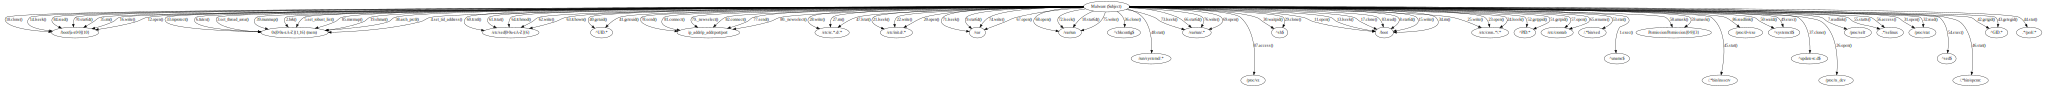

Xorddos-Intezer.csv raw doc OPset


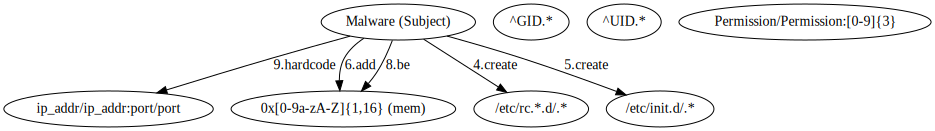

Xorddos-Intezer.csv matched doc OPset


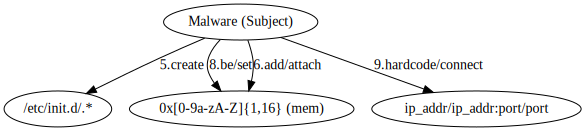

matched ASG OPset for doc Xorddos-Intezer.csv


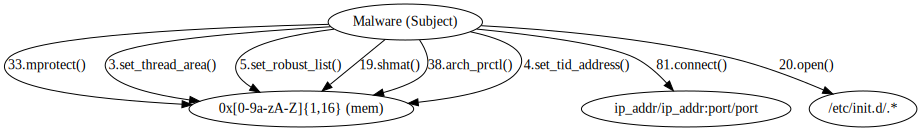

Xorddos-Ms.csv raw doc OPset


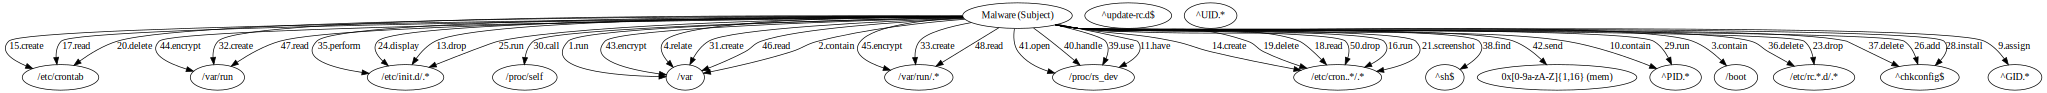

Xorddos-Ms.csv matched doc OPset


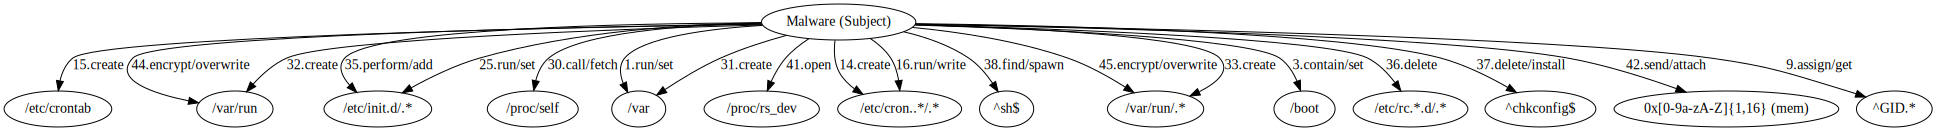

matched ASG OPset for doc Xorddos-Ms.csv


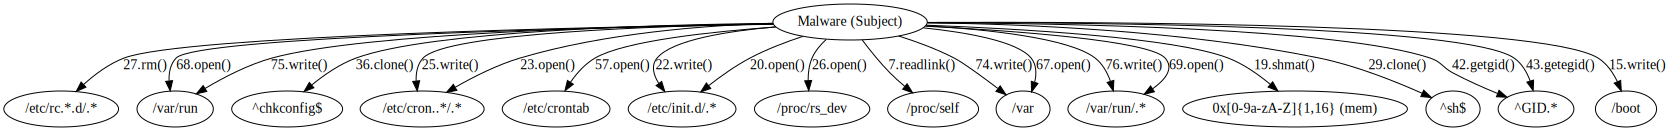

Xorddos-Trendmicro.csv raw doc OPset


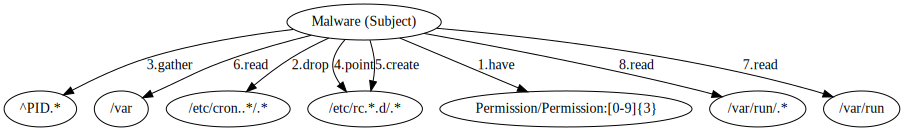

Xorddos-Trendmicro.csv matched doc OPset


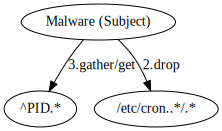

matched ASG OPset for doc Xorddos-Trendmicro.csv


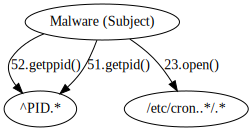

Xorddos-Trendmicro2.csv raw doc OPset


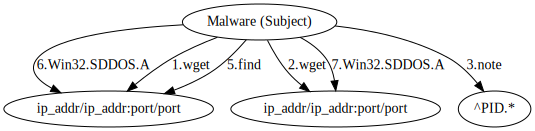

Xorddos-Trendmicro2.csv matched doc OPset


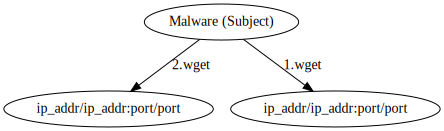

matched ASG OPset for doc Xorddos-Trendmicro2.csv


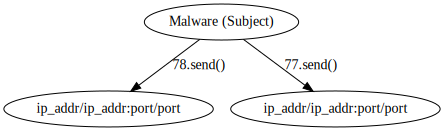

In [19]:
import graphviz

class ItemMapper:
    def __init__(self) -> None:
        self.mapper = {}
        self.index_counter:int = 1
        pass
    def addItem(self, item:str) -> str:
        # item = self.prettifyName(item) # 先不在這做~
        if item in self.mapper.keys():
            return self.mapper.get(item)
        self.mapper[item] = str(self.index_counter)
        self.index_counter += 1
        return str(self.index_counter - 1)
    def getSymbol(self, item:str):
        return self.mapper.get(item, None)

def draw_asg_op_graph(asg_OPset: list[OperationPair], family=None):
    dot = graphviz.Digraph(f'{family}_asg_OPset', comment='The Operational Pair Graph') 
    dot.node('Start', label="Malware (Subject)")
    mapper = ItemMapper()
    for op in asg_OPset:
        node_id = mapper.addItem(prettifyName(op.object))
        # dot.node(node_id, label=op.object)
        dot.node(node_id, label=prettifyName(op.object)) # rename partial regex
        if op.action:
            dot.edge('Start', node_id, label=f"{op.step_number}.{op.action}()") # syscall have braces end

    # dot.graph_attr.update(ratio="0.4")
    u = dot.unflatten(stagger=3, fanout=True)
    display(u)
    del mapper
    return u

def draw_ctd_op_graph(fset:FamilySet):
    for rem in fset.rem_lst:
        # doc_OPset
        if rem.doc_OPset is None or len(rem.doc_OPset) == 0:
            continue
        dot = graphviz.Digraph()
        dot.node('Start', label="Malware (Subject)")
        mapper = ItemMapper()
        for op in rem.doc_OPset:
            node_id = mapper.addItem(op.object)
            dot.node(node_id, label=prettifyName(op.object))
            if op.action:
                dot.edge('Start', node_id, label=f"{op.step_number}.{op.action}")
        print(f"{rem.reportname} raw doc OPset")
        display(dot)
        del mapper

        # match_doc_OPset
        if rem.match_doc_OPset is None or len(rem.match_doc_OPset) == 0:
            continue
        dot = graphviz.Digraph()
        dot.node('Start', label="Malware (Subject)")
        mapper = ItemMapper()
        for op in rem.match_doc_OPset:
            node_id = mapper.addItem(op.object)
            dot.node(node_id, label=prettifyName(op.object))
            if op.action:
                label = f"{op.step_number}.{op.action}/{op.altVerb}" if op.altVerb else f"{op.step_number}.{op.action}"
                dot.edge('Start', node_id, label=label)
        print(f"{rem.reportname} matched doc OPset")
        display(dot)
        del mapper

        # match_ASG_OPset
        if rem.OPset_order_index is None or len(rem.OPset_order_index) == 0:
            continue
        dot = graphviz.Digraph()
        dot.node('Start', label="Malware (Subject)")
        mapper = ItemMapper()
        for op in [fset.sample.OPset_ordered[i] for i in rem.OPset_order_index]:
            node_id = mapper.addItem(op.object)
            dot.node(node_id, label=prettifyName(op.object))
            if op.action:
                dot.edge('Start', node_id, label=f"{op.step_number}.{op.action}()")
        print(f"matched ASG OPset for doc {rem.reportname}")
        display(dot)
        del mapper
    return

opset_for_ppt, _ = construct_sample_OPset(asg.step_list, regexMaster, draw_memory_etc=True)
# draw_asg_op_graph(sample.OPset, family=family)
draw_asg_op_graph(opset_for_ppt, family=family)
draw_ctd_op_graph(fset)

In [20]:
type(sample.OPset)

for op in sample.OPset:
    if op.object_type == 'MEM':
        print(type(op), op, op.object) 
    # break

<class '__main__.OperationPair'> <OP33 act=mprotect(), obj=0x[0-9a-zA-Z]{1,16} (mem)> 0x[0-9a-zA-Z]{1,16}
<class '__main__.OperationPair'> <OP 6 act=futex(), obj=0x[0-9a-zA-Z]{1,16} (mem)> 0x[0-9a-zA-Z]{1,16}
<class '__main__.OperationPair'> <OP 3 act=set_thread_area(), obj=0x[0-9a-zA-Z]{1,16} (mem)> 0x[0-9a-zA-Z]{1,16}
<class '__main__.OperationPair'> <OP39 act=munmap(), obj=0x[0-9a-zA-Z]{1,16} (mem)> 0x[0-9a-zA-Z]{1,16}
<class '__main__.OperationPair'> <OP 2 act=brk(), obj=0x[0-9a-zA-Z]{1,16} (mem)> 0x[0-9a-zA-Z]{1,16}
<class '__main__.OperationPair'> <OP 5 act=set_robust_list(), obj=0x[0-9a-zA-Z]{1,16} (mem)> 0x[0-9a-zA-Z]{1,16}
<class '__main__.OperationPair'> <OP85 act=mremap(), obj=0x[0-9a-zA-Z]{1,16} (mem)> 0x[0-9a-zA-Z]{1,16}
<class '__main__.OperationPair'> <OP19 act=shmat(), obj=0x[0-9a-zA-Z]{1,16} (mem)> 0x[0-9a-zA-Z]{1,16}
<class '__main__.OperationPair'> <OP38 act=arch_prctl(), obj=0x[0-9a-zA-Z]{1,16} (mem)> 0x[0-9a-zA-Z]{1,16}
<class '__main__.OperationPair'> <OP 4 act=se

In [21]:
# for op in opset_for_ppt:
    # print(type(op), op)

### Run Script: print matched sentence for specific document

In [22]:
# 存檔所有 doc_OPset
def save_docOPset(fset: FamilySet) -> pd.DataFrame:
    data = []
    for idx_rem, rem in enumerate(fset.rem_lst):
        ctd_opset:list[OperationPair] = list(rem.doc_OPset)
        # print(rem.matched_syscalls)
        for op in ctd_opset:
            try:
                res = rem.matched_syscalls[(op.action, op.object)]
                a_syscalls = " ".join([f"{s}()" for s in res])
            except:
                a_syscalls = None
            data.append({
                'report': rem.reportname,
                'word': op.original_object,
                'verb': f"{op.action}/{op.altVerb}" if op.altVerb else op.action,
                'objectType': op.object_type,
                'prettyReg': prettifyName(op.object),
                'match': 1 if op in rem.match_doc_OPset else 0, # verb 是否有比對到 syscall
                'label': 1 if op in rem.match_doc_OPset else 0, # 人工標記的標籤 暫時先跟系統判斷一樣
                'asgSyscall': a_syscalls,                       # matched 到的動詞
                'sentence': " ".join(op.original_sentence.splitlines()) if op.original_sentence else None # flatten the sentence segment
            })
    # print(data)
    df = pd.DataFrame(data)
    df = df.sort_values(by=['report','objectType','prettyReg'])
    df.to_csv(f'./result/00_{family}_docOPset.csv', index=False)
    return df

df = save_docOPset(fset)
df

,report,word,verb,objectType,prettyReg,match,label,asgSyscall,sentence
7,Xorddos-Intezer.csv,/etc/init.d/po1kitd-update,create,FILE,/etc/init\.d/.*,1,1,open(),The following files are created after executin...
2,Xorddos-Intezer.csv,/usr/syno/etc/rc.d/S99po1kitd-update.sh,create,FILE,/etc/rc.*\.d/.*,0,0,None,The following files are created after executin...
8,Xorddos-Intezer.csv,"permission,",None,FILE,Permission/Permission:[0-9]{3},0,0,None,The file’s data used in both functions are: pa...
4,Xorddos-Intezer.csv,GID,None,ID,^GID.*,0,0,None,Figure 3: Similarity between PWNLNX and RedXOR...
6,Xorddos-Intezer.csv,UID,None,ID,^UID.*,0,0,None,Figure 3: Similarity between PWNLNX and RedXOR...
...,...,...,...,...,...,...,...,...,...
68,Xorddos-Trendmicro2.csv,http://122.51.133.49:10086/VIP,Win32.SDDOS.A,NET,ip_addr/ip_addr:port/port,0,0,None,Indicators of Compromise Kaiji File name\tSH...
69,Xorddos-Trendmicro2.csv,http://122.51.133.49:10086/VIP,wget,NET,ip_addr/ip_addr:port/port,1,1,send(),"Afterwards, the attackers executed the followi..."
70,Xorddos-Trendmicro2.csv,http://122.51.133.49:10086/VIP,wget,NET,ip_addr/ip_addr:port/port,1,1,send(),"Afterwards, the attackers executed the followi..."
71,Xorddos-Trendmicro2.csv,http://62.171.160.189/linux_arm,find,NET,ip_addr/ip_addr:port/port,0,0,None,Indicators of Compromise Kaiji File name\tSH...


In [23]:
df_ = df[df['report'] == 'Dofloo-SyscallParty.csv']['sentence'].unique()
len(df_ )

0

PPT Data: 挑選一篇目標文件，列出 ST 和 OP 資料，以便作為簡報內容。

In [24]:
# target document: Gafgyt-sectrio.csv (docs_id = 2)
d = {
    "Dofloo": "Dofloo-SyscallParty.csv", # Dofloo-SyscallParty.csv Securityaffairs Dofloo-Trendmicro.csv
    "Xorddos": "Xorddos-Intezer.csv",
    "Gafgyt": "Gafgyt-sectrio.csv",
    "Luabot": "Luabot-malwaremustdie.csv",
    "Darlloz": "",
    "Kaiten": "",
    "Lupper": "",
    "Turla": "",
}
t_docs = d[family]
t_docs_id = xor_report_names.index(t_docs)

# Gather Special Token data.
# Columns: Matched ST (regex), Entity Type, Original Sentence
# Present Order: Sort by Entity Type then regex string.
df_docs = df[df['report'] == t_docs]
df_docs.sort_values(by=['objectType', 'prettyReg'])
print(f"Special Token data: (id#{t_docs_id} {t_docs})")
display(df_docs.loc[:, ['prettyReg', 'word', 'objectType', 'sentence']])

# Gather Operation Pair data.
# Columns: Original Sentence (+action, object-word), Mapped Syscall, Matched ASG OP
# Present Order: Sort by Sentence string
oe = OperationEvaluator()
def get_syscall_by_verb(verb, entityType) -> str|None:
    try:
        altVerb = verb.split('/')[1]
        result = oe.translate_rule(entityType, altVerb)
    except:
        altVerb = None
        result = oe.translate_rule(entityType, verb)
    if result:
        return " ".join([f"{s}()" for s in result])
    return None
df_op = df_docs[df_docs['verb'].notnull()]    # 過濾掉沒有動詞的 OP
df_op = df_op[df_op['asgSyscall'].notnull()]  # 過濾掉動詞沒有對應 syscall 的 OP
df_op.sort_values(by=['sentence', 'objectType', 'prettyReg'])
df_op['mappedSyscall'] = df_op.apply(lambda x: get_syscall_by_verb(x['verb'], x['objectType']), axis=1)

print("Operation Pair data:")
# print(df_docs.loc[:, ['sentence', 'verb', 'altVerb', 'mappedSyscall', 'asgSyscall', 'prettyReg']])
display(df_op.loc[:, ['sentence', 'verb', 'mappedSyscall', 'asgSyscall', 'prettyReg']])

Special Token data: (id#2 Xorddos-Intezer.csv)


,prettyReg,word,objectType,sentence
7,/etc/init\.d/.*,/etc/init.d/po1kitd-update,FILE,The following files are created after executin...
2,/etc/rc.*\.d/.*,/usr/syno/etc/rc.d/S99po1kitd-update.sh,FILE,The following files are created after executin...
8,Permission/Permission:[0-9]{3},"permission,",FILE,The file’s data used in both functions are: pa...
4,^GID.*,GID,ID,Figure 3: Similarity between PWNLNX and RedXOR...
6,^UID.*,UID,ID,Figure 3: Similarity between PWNLNX and RedXOR...
1,"0x[0-9a-zA-Z]{1,16} (mem)",0x0,MEM,The data is added to a struct with the followi...
5,"0x[0-9a-zA-Z]{1,16} (mem)",0x8,MEM,0x8 Content-Length as long 0x10 Total-Lengt...
9,"0x[0-9a-zA-Z]{1,16} (mem)",0x18,MEM,0x8 Content-Length as long 0x10 Total-Lengt...
0,ip_addr/ip_addr:port/port,158.247.208.230,NET,Network update.cloudjscdn.com 158.247.208.230...
3,ip_addr/ip_addr:port/port,127.0.0.1,NET,Table 2: Data collected by the malware and sen...


Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertModel: ['cls.predictions.bias', 'cls.seq_relationship.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.decoder.weight', 'cls.predictions.transform.dense.bias', 'cls.seq_relationship.bias']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


Operation Pair data:


,sentence,verb,mappedSyscall,asgSyscall,prettyReg
7,The following files are created after executin...,create,dup() dup2() open() mmap() link(),open(),/etc/init\.d/.*
1,The data is added to a struct with the followi...,add/attach,shmdt() shmat(),shmat(),"0x[0-9a-zA-Z]{1,16} (mem)"
9,0x8 Content-Length as long 0x10 Total-Lengt...,be/set,mprotect() set_tid_address() arch_prctl() set_...,mprotect() set_thread_area() set_robust_list()...,"0x[0-9a-zA-Z]{1,16} (mem)"
3,Table 2: Data collected by the malware and sen...,hardcode/connect,connect(),connect(),ip_addr/ip_addr:port/port


In [25]:
# 找出 op 對應的的全部 asg steps
Utility.query_origin_steplist(asg, 'mprotect', 'Memory Address') # 0x[0-9a-zA-Z]{1,16} no result
# Utility.query_origin_steplist(asg, 'read', r'/proc/net/dev')

['  78. 1521    -> mprotect() -> Memory Address',
 ' 930. update-rc.d -> mprotect() -> Memory Address',
 ' 987. sh      -> mprotect() -> Memory Address',
 '1003. sed     -> mprotect() -> Memory Address',
 '1138. systemctl -> mprotect() -> Memory Address']

In [ ]:
step_lst = Utility.query_origin_steplist(asg, 'set_tid_address', 'Memory Address')
step_lst = [string.split('.')[0].strip() for string in step_lst]
step_lst = [f"Step.{num}" for num in step_lst]
print(len(step_lst))
for step in step_lst:
    print(step)

In [29]:
df_op.loc[14, 'sentence']

'We then read data from the C2, but first, we zero out the buffer that we are using and have a maximum size of 0x1380 that we want to receive.'

列印其他小數據

In [24]:
oe.translate_rule('mem', 'set')

['mprotect',
 'set_tid_address',
 'arch_prctl',
 'set_thread_area',
 'set_robust_list']

In [25]:
df_docs.loc[22].sentence

" It terminates the following processes if found running in the affected system's memory:  inetd xinetd telnetd utelnetd scfgmgr Other Details  This Worm does the following:  It terminates and deletes the following processes and files: /var/run/.lightpid /var/run/.aidrapid /var/run/lightpid /var/run/.lihtpid /var/run/.lamorte/lamorte.pid /var/run/.daemon.pid "

In [24]:
# 印出特定 report 的 matched 句子
report_id = 5
reportname = fset.rem_lst[report_id].reportname
print(f"Report: {reportname}. Matched OP count: {len(fset.rem_lst[report_id].match_doc_OPset)}")
for i, op in enumerate(fset.rem_lst[report_id].match_doc_OPset):
    print(f"--\nOP #{op.step_number} {op.action} {op.object} {op.original_object}")
    print(f"{op.original_sentence}")

Report: Darlloz-Trendmicro2.csv. Matched OP count: 2
--
OP #2 create /var/run/.* /var/run/.zollard

This Worm creates the following folders:

/var/run/.zollard


--
OP #1 create /run/.* /var/run/.zollard

This Worm creates the following folders:

/var/run/.zollard




In [18]:
# 測試區
for rem in fset.rem_lst:
    print(rem.doc_OPset)

{<OP 8 act=contain, obj=sh>, <OP 2 act=expose, obj=sed>, <OP 4 act=allow, obj=sed>, <OP11 act=None, obj=sed>, <OP 3 act=assemble, obj=sed>, <OP12 act=use, obj=sh>, <OP 1 act=scan, obj=sed>, <OP10 act=disclose, obj=sed>, <OP 5 act=gain, obj=sh>, <OP 6 act=depend, obj=sed>, <OP 7 act=execute, obj=sh>, <OP 9 act=contain, obj=sed>}
{<OP 4 act=use, obj=sed>, <OP 7 act=None, obj=sed>, <OP 1 act=be, obj=PID.*>, <OP11 act=add, obj=sh>, <OP 6 act=None, obj=sh>, <OP 9 act=None, obj=ip_addr>, <OP 2 act=decide, obj=sh>, <OP 5 act=have, obj=sh>, <OP12 act=explain, obj=sh>, <OP10 act=be, obj=sed>, <OP 3 act=be, obj=sh>, <OP 8 act=be, obj=ip_addr>}
{<OP 4 act=connect, obj=ip_addr>, <OP 5 act=receive, obj=sh>, <OP 2 act=download, obj=sh>, <OP 1 act=read, obj=sh>, <OP 8 act=None, obj=sed>, <OP 3 act=None, obj=sh>, <OP 7 act=None, obj=/etc/rc.*\.d/.*>, <OP 6 act=modify, obj=/etc/rc\.local>, <OP 9 act=be, obj=sh>}
{<OP 8 act=use, obj=sed>, <OP 2 act=None, obj=sed>, <OP21 act=None, obj=ip_addr>, <OP13 act

In [19]:
for rem in fset.rem_lst:
    display(rem.get_match_sentences())
    break

,bin/sed,/etc/rc,/etc/init.d/,/proc/,/etc/sed,/selinux,/sys/,bin/,lsb-release,uname(.)($),...,^sh$,^sed$,"\d{1,3}\.\d{1,3}\.\d{1,3}\.\d{1,3}:\d+","\d{1,3}\.\d{1,3}\.\d{1,3}\.\d{1,3}",eth[0-9]$,0x[0-9a-zA-Z]{8},"permission:{0,1}[0-9]{0,4}",UID,GID,match
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
5,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
6,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
7,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
8,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
9,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
